### Import packages-libraries

In [1]:
import pandas as pd
import numpy as np

import urllib3
import requests
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from nltk.stem.porter import *
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.metrics import accuracy_score
import nltk

nlp = spacy.load('en_core_web_sm')
nltk.download('punkt')

%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Read from file

In [2]:
train_data = pd.read_csv('datasets/q1/train.csv', sep=',')
test_data = pd.read_csv('datasets/q1/test_without_labels.csv', sep=',')
#test_data['Label'] = train_data['Label']
expected_array = np.array(train_data.head(2000)[['Label']]).flatten()
content_array = np.array(train_data.head(2000)[['Content']]).flatten()
#X_train = train_data['Content'].head(2000)
#Y_train = train_data['Label'].head(2000)
#X_test = test_data['Content']
#Y_test = test_data['Label']

my_additional_stop_words = ['said','still','day','will','new','may','two','one','now','time','say','second','month','first','going','year','back','people','case','according']
stop_words = STOPWORDS.union(my_additional_stop_words)

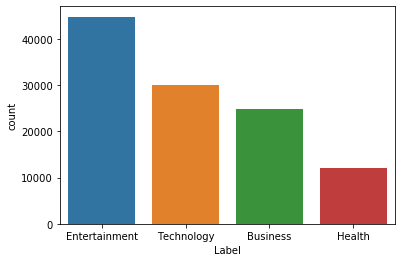

In [3]:
sns.countplot(x='Label',data=train_data)

In [4]:
traindata = train_data.groupby('Label').count()
print(traindata)

                  Id  Title  Content
Label                               
Business       24834  24834    24834
Entertainment  44834  44834    44834
Health         12020  12020    12020
Technology     30107  30107    30107


### Cleaning Data

In [3]:
df_entertainment = train_data[train_data['Label']=='Entertainment'].head(3900)
#df_health = train_data[train_data['Label']=='Health'].head(1000)
df_health = train_data[train_data['Label']=='Health'].head(1200)
df_business = train_data[train_data['Label']=='Business'].head(2700)
#df_technology = train_data[train_data['Label']=='Technology'].head(2900)
df_technology = train_data[train_data['Label']=='Technology'].head(3000)
df = pd.concat([df_entertainment,df_health,df_business,df_technology])

#X_train = df['Content']
#Y_train = df['Label']
#X_test = df['Content']
#Y_test = test_data['Label']

X = df['Title']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

set(df['Label'])
le = preprocessing.LabelEncoder()
le.fit(df['Label'])
y = le.transform(df['Label'])
set(y)

{0, 1, 2, 3}

### Wordcloud 

In [6]:
    #STOPWORDS.extend(['will', 'said', 'us', 'may', 'share','well'])
def wordcloud():
    business = str()
    entertainment = str()
    health = str()
    technology = str()
    for i in range(expected_array.shape[0]):
        if expected_array[i] == 'Business':
            business = business + ' ' + str(content_array[i])
        elif expected_array[i] == 'Entertainment':
            entertainment = entertainment + ' ' + str(content_array[i])
        elif expected_array[i] == 'Health':
            health = health + ' ' + str(content_array[i])
        elif expected_array[i] == 'Technology':
            technology = technology + ' ' + str(content_array[i])

    mask = np.array(Image.open(requests.get('http://www.clker.com/cliparts/3/0/a/1/11971238241310805346noonespillow_Simple_Cloud.svg.med.png',stream=True).raw))

    wordcloud1 = WordCloud(stopwords=stop_words, background_color="white", mask=mask).generate(business)
    plt.imshow(wordcloud1,interpolation='bilinear')
    plt.axis("off")
    plt.savefig('q1/business.png')

    wordcloud2 = WordCloud(stopwords=stop_words,background_color="white",mask=mask).generate(entertainment)
    plt.imshow(wordcloud2,interpolation='bilinear')
    plt.axis("off")
    plt.savefig('q1/entertainment.png')

    wordcloud3 = WordCloud(stopwords=stop_words,background_color="white",mask=mask).generate(health)
    plt.imshow(wordcloud3,interpolation='bilinear')
    plt.axis("off")
    plt.savefig('q1/health.png')

    wordcloud4 = WordCloud(stopwords=stop_words,background_color="white",mask=mask).generate(technology)
    plt.imshow(wordcloud4,interpolation='bilinear')
    plt.axis("off")
    plt.savefig('q1/technology.png')

IndentationError: expected an indented block (<ipython-input-6-20c09ce7e3a9>, line 3)

In [7]:
#wordcloud()

### Building Vectors

In [4]:
print("building tfidf")

#vectorizer = TfidfVectorizer(stop_words = 'english', max_df=0.9, min_df=3)
vectorizer = TfidfVectorizer(stop_words = 'english', use_idf=True)
X_train_tfidf = vectorizer.fit_transform(X_train) 
X_test_vect = vectorizer.transform(X_test) 

print("Building SVD")
#truncated svd
lsa=TruncatedSVD(n_components = 80)
svd_transformer = make_pipeline(vectorizer,lsa)
X_train_svd = svd_transformer.fit_transform(X_train)

building tfidf
Building SVD


### SVM (Bag of Words)

In [9]:
#set candidate parameters
parameters = {'kernel':['rbf'], 'C': [4,8,16], 'gamma': [0.1,0.01]}

print("before determing model")

#determine the model
svc = SVC()
clf = GridSearchCV(svc,parameters,cv=5)

print("before feeding data")
# Feed the training data
clf.fit(X_train_tfidf, y_train)  

print("before predicting")
predictions = clf.predict(X_test_vect)
#preds = le.inverse_transform(predictions )

print("accuracy:",end=' ')
print(accuracy_score(y_test,predictions))
print("\n")
print(metrics.classification_report(y_test,predictions))

dfr = classification_report(y_test,predictions,output_dict = True)
macro_precision = dfr['macro avg']['precision']
macro_recall = dfr['macro avg']['recall']
macro_f1 = dfr['macro avg']['f1-score']

before determing model
before feeding data
before predicting
accuracy: 0.8883116883116883


               precision    recall  f1-score   support

     Business       0.83      0.85      0.84       859
Entertainment       0.92      0.95      0.94      1312
       Health       0.89      0.79      0.84       338
   Technology       0.90      0.87      0.88       956

     accuracy                           0.89      3465
    macro avg       0.88      0.86      0.87      3465
 weighted avg       0.89      0.89      0.89      3465



### SVM (svd)

In [12]:
parameters2 = {'kernel':['rbf'], 'C': [4,8,16], 'gamma': [0.1,0.01]}
s2 = SVC()
s = GridSearchCV(s2,parameters2, cv=5)

#scores=cross_val_score(s,X_train_svd,y,cv=5,scoring='accuracy')
#score= scores.mean()
#print (score)
predicted = cross_val_predict(s, X_train_svd, y, cv=5) #5-fold cross validation
print (accuracy_score(y, predicted)) 

print("accuracy:",end=' ')
print(metrics.accuracy_score(y,predicted))
print("\n")

print(classification_report(y,predicted))

dfr2 = classification_report(y,predicted,output_dict = True)
macro_precision2 = dfr2['macro avg']['precision']
macro_recall2 = dfr2['macro avg']['recall']
macro_f12 = dfr2['macro avg']['f1-score']

0.6955238095238095
accuracy: 0.6955238095238095


              precision    recall  f1-score   support

           0       0.67      0.64      0.65      2700
           1       0.64      0.93      0.76      3900
           2       0.80      0.38      0.51      1000
           3       0.87      0.54      0.67      2900

    accuracy                           0.70     10500
   macro avg       0.75      0.62      0.65     10500
weighted avg       0.73      0.70      0.68     10500



### Random Forests (Bag of words)

In [13]:
rfc1 = RandomForestClassifier(n_estimators=100)
params = {'n_estimators':[100]}
rfc = GridSearchCV(rfc1,params, cv=5)
rfc.fit(X_train_tfidf, y_train)
rfc_pred = rfc.predict(X_test_vect)

print("accuracy:",end=' ')
print(accuracy_score(y_test,rfc_pred))
print("\n")

print(metrics.classification_report(y_test,rfc_pred))

dfr3 = classification_report(y_test,rfc_pred,output_dict = True)
macro_precision3 = dfr3['macro avg']['precision']
macro_recall3 = dfr3['macro avg']['recall']
macro_f13 = dfr3['macro avg']['f1-score']

accuracy: 0.8216450216450216


               precision    recall  f1-score   support

     Business       0.83      0.71      0.77       859
Entertainment       0.77      0.96      0.85      1312
       Health       0.87      0.67      0.76       338
   Technology       0.90      0.79      0.84       956

     accuracy                           0.82      3465
    macro avg       0.84      0.78      0.80      3465
 weighted avg       0.83      0.82      0.82      3465



### Random Forests (svd)

In [14]:
m = RandomForestClassifier(n_estimators = 100)
#scores=cross_val_score(m,X,y,cv=5,scoring='accuracy')

r_predicted = cross_val_predict(m, X_train_svd, y, cv=5) #5-fold cross validation
print("accuracy:",end=' ')
print(accuracy_score(y,r_predicted))
print("\n")
print (accuracy_score(y, r_predicted))
print(metrics.classification_report(y,r_predicted))

dfr4 = classification_report(y,r_predicted,output_dict = True)
macro_precision4 = dfr4['macro avg']['precision']
macro_recall4 = dfr4['macro avg']['recall']
macro_f14 = dfr4['macro avg']['f1-score']

accuracy: 0.782952380952381


0.782952380952381
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      2700
           1       0.80      0.90      0.85      3900
           2       0.82      0.52      0.64      1000
           3       0.82      0.72      0.76      2900

    accuracy                           0.78     10500
   macro avg       0.79      0.73      0.75     10500
weighted avg       0.79      0.78      0.78     10500



### My Method

In [15]:
#test_id = test_data['Id'].tolist()
#clue = train_data.loc[train_data['Id'].isin(test_id)]
#test_id = pd.Series(test_data['Id'])
#td = train_data[train_data['Id'].isin([i])]


In [ ]:
nltk.download('stopwords')
stopWords = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import re

stopWords.extend(['saying', 'said', 'say', 'yes', 'instead', 'meanwhile', 'right', 'really', 'finally', 'now', 
                       'one', 'suggested', 'says', 'added', 'think', 'know', 'though', 'let', 'going', 'back',
                       'well', 'example', 'us', 'yet', 'perhaps', 'actually', 'oh', 'year', 'lastyear',
                       'last', 'old', 'first', 'good', 'maybe', 'ask', '.', ',', ':', 'take', 'made', 'n\'t', 'go', 
                       'make', 'two', 'got', 'took', 'want', 'much', 'may', 'never', 'second', 'could', 'still', 'get', 
                       '?', 'would', '(', '\'', ')', '``', '/', "''", '%', '#', '!', 'next', "'s", ';', '[', ']', '...',
                       'might', "'m", "'d", 'also', 'something', 'even', 'new', 'lot', 'a', 'thing', 'time', 'way',
                       'always', 'whose', 'need', 'people', 'come', 'become', 'another', 'many', 'must', 'too', 'as', 'well'])

stopWords.extend([' ','are','and','I','A','And','So','arnt','This','When','It','many','Many','so','cant','Yes','yes','No','no','These','these'])

def processText(text):
    #text = text.lower()
    #text = re.sub("\'s", " ", text)
    #text = re.sub("\'ve", " have ", text)
    #text = re.sub("cannot", "can't", text)
    #text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    #text = re.sub("n't", " not ", text)
    #text = re.sub("\'re", " are ", text)
    #text = re.sub("\'d", " would ", text)
    #text = re.sub("\'ll", " will ", text)
    #text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    #text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    #text = re.sub('\&', " and ", text)
    
    p_stemmer = SnowballStemmer(language='english')
    text = re.sub(r'[^\w\s]','',text)
    tokens = text.lower()
    tokens = tokens.split()
    tokens = [wrd for wrd in tokens if(wrd not in stopWords)]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    tokens = [wrd for wrd in tokens if(wrd not in stopWords)]
    stems = [p_stemmer.stem(t) for t in tokens]
    return stems


X = 'ttt '+ df['Title']+' ttt '+ df['Title']+' ccc '+df['Content']+' ttt '+df['Title']+' ttt '+ df['Title']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


vectorizer = TfidfVectorizer(tokenizer=processText, stop_words = stop_words, use_idf=True)
X_train_tfidf = vectorizer.fit_transform(X_train) 
X_test_vect = vectorizer.transform(X_test) 

#params2 = {'alpha':[1], 'norm':[True]}
params2 = {'kernel':['rbf'], 'C': [8], 'gamma': [0.1]}

#nb2 = ComplementNB(alpha=1, norm=True)
nb2 = SVC()
nb = GridSearchCV(nb2,params2,cv=5)

nb.fit(X_train_tfidf, y_train)
pred5 = nb.predict(X_test_vect)

print("accuracy:",end=' ')
print(accuracy_score(y_test,pred5))
print("\n")
print(classification_report(y_test,pred5))

dfr5 = classification_report(y_test,pred5,output_dict = True)
macro_precision5 = dfr5['macro avg']['precision']
macro_recall5 = dfr5['macro avg']['recall']
macro_f15 = dfr5['macro avg']['f1-score']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\python\python37\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['accord', 'arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'els', 'hadnt', 'hasnt', 'havent', 'hed', 'hell', 'henc', 'howev', 'id', 'ill', 'im', 'isnt', 'ive', 'mustnt', 'otherwis', 'shant', 'shed', 'shell', 'shes', 'shouldnt', 'sinc', 'therefor', 'theyd', 'theyll', 'theyr', 'theyv', 'wasnt', 'wed', 'werent', 'weve', 'wont', 'wouldnt', 'youd', 'youll', 'youv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
nb.best_params_

### Predicting Test file

In [7]:
df_test = 'ttt '+ test_data['Title']+' ttt '+ test_data['Title']+' ccc '+test_data['Content']+' ttt '+test_data['Title']+' ttt '+ test_data['Title']
X_test_vector = vectorizer.transform(df_test)

In [8]:
pred_final = nb.predict(X_test_vector)

In [9]:
to_print_arr = np.array(test_data[['Id']]).flatten()
columns = pd.Index(['Id','Predicted'])
data = np.column_stack((to_print_arr,pred_final))
df_final = pd.DataFrame(data, index=None, columns = columns)
df_final.to_csv('q1/testSet_categories.csv', sep=',', index=False)

### Benchmark 2

In [16]:
import csv

name=['Id','Predicted']

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
    
stemmer = SnowballStemmer("english", ignore_stopwords=True)

def benchmark2(df, df_test):
    df['Content'] = df['Content'].str.replace('[^\w\s]','')
    df['Content'] = df['Content'].str.lower()

    df['Title'] = df['Title'].str.replace('[^\w\s]','')
    df['Title'] = df['Title'].str.lower()

    df_test['Content'] = df_test['Content'].str.replace('[^\w\s]','')
    df_test['Content'] = df_test['Content'].str.lower()

    df_test['Title'] = df_test['Title'].str.replace('[^\w\s]','')
    df_test['Title'] = df_test['Title'].str.lower()

    df['Text'] = df['Title'] + ' ' + df['Content']
    X_train=df['Text']

    df_test['Text'] = df_test['Title'] + ' ' + df_test['Content']
    X_test=df_test['Text']

    column0=df_test['Id']
    print (len(column0))

    le=LabelEncoder()
    Y_train=le.fit_transform(df['Label'])

    svd=TruncatedSVD(n_components=40)
    stemmed_count_vect = StemmedCountVectorizer(stop_words=ENGLISH_STOP_WORDS)
    #clf=RandomForestClassifier()
    clf = SVC(kernel='linear')
    pipeline = Pipeline([('vect',stemmed_count_vect),('tfidf', TfidfTransformer()),('svd',svd),('clf', clf)])
        #Pipeline Fit
    pipeline.fit(X_train,Y_train)
        #Predict the train set
    predicted=pipeline.predict(X_test)

    column1=le.inverse_transform(predicted)
    print (len(column1))

    to_print_arr = np.array(df_test[['Id']]).flatten()
    columns = pd.Index(['Id','Predicted'])
    data = np.column_stack((to_print_arr,column1))
    df_final = pd.DataFrame(data, index=None, columns = columns)
    df_final.to_csv('q1/testSet_categories.csv', sep=',', index=False)

In [17]:
#df_b = train_data.head(10000)
#df_b_t = test_data
#benchmark2(df_b,df_b_t)

c:\python\python37\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
c:\python\python37\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\python\python37\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

47912
47912


### Requirement 1 complete